## SNIPPET 7.1 Composition of blaock diagonal correlation matrices

In [11]:
import matplotlib.pyplot as mpl, seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Snippet 2.7
from scipy.linalg import block_diag

def formBlockMatrix(nBlocks, bSize, bCorr) :
    # make square matrix (bSize * bSize) (all elements' value is bCorr)
    block = np.ones((bSize, bSize)) * bCorr
    
    # change diagonal elements to 1
    block[range(bSize), range(bSize)] = 1
    
    # Make block diagonal matrix with size (bSize*nBlocks by bSize*nBlocks)
    corr = block_diag(*([block]*nBlocks))
    
    return corr

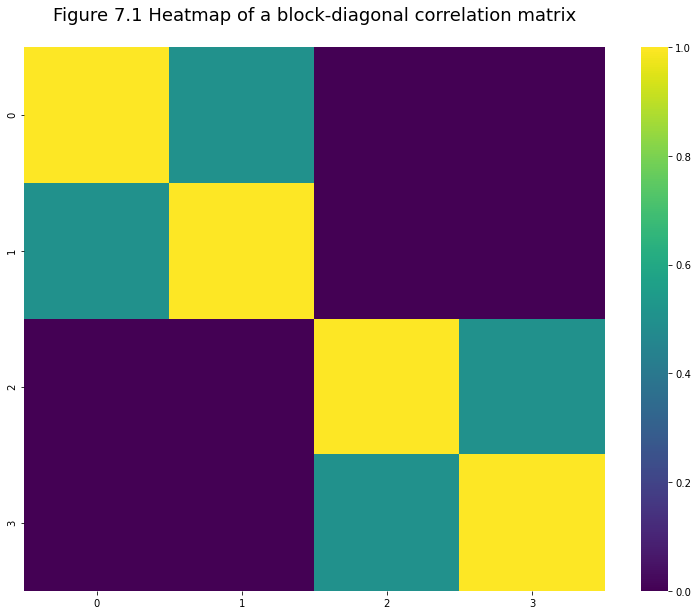

In [13]:
corr0 = formBlockMatrix(2, 2,0.5)
eVal, eVec = np.linalg.eigh(corr0)
# print(max(eVal / min(eVal)))

fig, ax = plt.subplots(figsize=(13,10))    
ax.set_title('Figure 7.1 Heatmap of a block-diagonal correlation matrix\n', fontsize=18)
sns.heatmap(corr0, cmap='viridis')
plt.show()

## SNIPPET 7.2 BLOCK-DIAGONAL CORRELATION MATRIX WITH A DOMINANT BLOCK

In [14]:
corr0 = block_diag(formBlockMatrix(1,2,0.5))

corr1 = formBlockMatrix(1,2,.0)

corr0 = block_diag(corr0, corr1)

eVal, eVec = np.linalg.eigh(corr0)

print(max(eVal)/ min(eVal))

3.0


## SNIPPET 7.3 THE CORRELATION CLUSTERING STEP

In [29]:
from sklearn.neighbors.kde import KernelDensity

# Snippet 2.1
def mpPDF(var, q, pts):
    # Marcenko-Pastur pdf
    # q = T/N
    eMin = var * (1 - (1.0 / q) ** 0.5) ** 2
    eMax = var * (1 + (1.0 / q) ** 0.5) ** 2
    
    eVal = np.linspace(eMin, eMax, pts)
    
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** 0.5
    
    if len(pdf.shape) > 1 :
        pdf = pdf.squeeze()
    
    pdf = pd.Series(pdf, index = eVal)
    
    return pdf

# Snippet 2.2
def getPCA(matrix) :
    
    # Get eVal, eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1] # arguments for sorting eVal desc
    
    eVal = eVal[indices]
    eVec = eVec[:, indices]
    
    eVal = np.diagflat(eVal)
    
    return eVal, eVec

def fitKDE(obs, bWidth = 0.25, kernel = 'gaussian', x=None) :
    # Fit kernel to a series of obs, and derive the probability of obs
    # x : the array of values on which the fit KDE will be evaluated
    
    if len(obs.shape) == 1 :
        obs = obs.reshape(-1,1)
        
    if x is None :
        x = np.unique(obs).reshape(-1, 1)
        
    if len(x.shape) == 1 :
        x = x.reshape(-1, 1)
        
    kde = KernelDensity(kernel = kernel, bandwidth = bWidth).fit(obs)
    
    logProb = kde.score_samples(x) #log(density)
    pdf = pd.Series(np.exp(logProb), index = x.flatten())
    
    return pdf

# Snippet 2.3
def cov2corr(cov) :
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std,std)
    
    # Clipping to prevent numerical errors
    corr[corr <-1] = -1
    corr[corr > 1] = 1
    
    return corr

# Snippet 2.4 
from scipy.optimize import minimize

def errPDFs(var, eVal, q, bWidth, pts = 1000) :
    # Fit error
    # Theoretical pdf
    
    # prevent var values in list format
    if hasattr(var, "__len__") :
        if len(var) == 1 :
            var = var[0]
        else :
            raise ValueErroral ("var  must be scalar")
    
    
    pdf0 = mpPDF(var, q, pts)
    # Empirical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)
    sse = np.sum((pdf1 - pdf0)**2)
    
    return sse


def findMaxEval(eVal, q, bWidth) :
    # Find Max random eVal by fitting Marcenko's distribution
    
    # Scipy.optimize.minimize
    # fun : Theobjective function to be minimized
    # x0 : ndarray, shape(n,), initial guess. array of real emlements of size
    
    out = minimize(fun = lambda *x : errPDFs(*x), x0 = .5, # first arg : var
                   args = (eVal, q, bWidth), bounds = ((1e-5, 1 - 1e-5),))
    
    if out['success'] :
        var = out['x'][0]
    else :
        var = 1
        
    eMax = var * (1 + (1.0 / q) ** 0.5) ** 2
    
    return eMax, var

# Snippet 2.5
def denoisedCorr(eVal, eVec, nFacts):
    # Remove noise from corr by fixing randome eigenvalues
    
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum() / float(eVal_.shape[0] - nFacts)
    eVal_ = np.diag(eVal_)
    
    corr1 = np.dot(eVec, eVal_).dot(eVec.T)
    corr1 = cov2corr(corr1)
    
    return corr1

# Snippet 2.7
def formBlockMatrix(nBlocks, bSize, bCorr) :
    # make square matrix (bSize * bSize) (all elements' value is bCorr)
    block = np.ones((bSize, bSize)) * bCorr
    
    # change diagonal elements to 1
    block[range(bSize), range(bSize)] = 1
    
    # Make block diagonal matrix with size (bSize*nBlocks by bSize*nBlocks)
    corr = block_diag(*([block]*nBlocks))
    
    return corr


def formTrueMatrix(nBlocks, bSize, bCorr) :
    
    # make BlockMatrix in DataFrame Format
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    
    # make columns index to list and shuffle
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    
    # corr matrix shuffled along column & index
    corr0 = corr0[cols].loc[cols].copy(deep=True)
    
    # final calculations
    std0 = np.random.uniform(low = 0.05, high = 0.2, size = corr0.shape[0])
    cov0 = corr2cov(corr0, std0)
    mu0 = np.random.normal(loc = std0, scale = std0, size = cov0.shape[0]).reshape(-1,1)
    
    return mu0, cov0

# Snippet 2.8
def simCovMu(mu0, cov0, nObs, shrink=False):
    
    # TODO add comments
    x = np.random.multivariate_normal(mu0.flatten(), cov0, size = nObs)
    
    mu1 = x.mean(axis = 0).reshape(-1,1)
    
    if shrink :
        cov1 = LedoitWolf().fit(x).covariance_
    else :
        cov1 = np.cov(x, rowvar = 0)
    
    return mu1, cov1

# Snippet 2.9
def corr2cov(corr, std):
    cov = corr * np.outer(std,std)
    return cov

def deNoiseCov(cov0, q, bWidth):
    
    # TODO add comments
    corr0 = cov2corr(cov0)
    eVal0, eVec0 = getPCA(corr0)
    eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth)
    
    # Finding noise starting point
    nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
    
    corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
    
    cov1 = corr2cov(corr1, np.diag(cov0)** 0.5)
    
    return cov1

# Snippet 4.1
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
def clusterKMeansBase(corr0, maxNumClusters = 10, n_init = 10) :

    x = ((1-corr0.fillna(0))/2)**0.5
    silh = pd.Series()   # Observations matrix
    
    for init in range(n_init) :
        for i in range (2, maxNumClusters +1) :
            kmeans_ = KMeans(n_clusters = i, n_init=1)
            kmeans_ = kmeans_.fit(x)
            
            silh_ = silhouette_samples(x, kmeans_.labels_)
            stat = (silh_.mean() / silh_.std(), silh.mean()/silh.std())
            
            if np.isnan(stat[1]) or stat[0] > stat[1] :
                silh = silh_
                kmeans = kmeans_
    
    # Reordering
    newIdx = np.argsort(kmeans.labels_)
    corr1 = corr0.iloc[newIdx] # reorder rows
    corr1 = corr1.iloc[:, newIdx] # reorder columns
    
    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() \
             for i in np.unique(kmeans.labels_)}  # cluster members
    silh = pd.Series(silh, index = x.index)
    
    return corr1, clstrs, silh
    

In [31]:
import pandas as pd

# generate covariance matrix using simCovMu at snippet 2.8
nBlocks = 10
bSize = 50
bCorr = 0.5
np.random.seed(0)

mu, cov = formTrueMatrix(nBlocks, bSize, bCorr)

# nObs = 1000
# mu0, cov0 = simCovMu(mu, cov, nObs, shrink=False)

cols = cov.columns
cov1 = deNoiseCov(cov0, len(cols)/2, bWidth=0.01)
cov1 = pd.DataFrame(cov1, index=cols, columns=cols)
corr1 = cov2corr(cov1)
corr1, clstrs,silh = clusterKMeansBase(corr1, maxNumClusters= int(corr0.shape[0]/2), n_init=10)